In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')

device: cuda:0


In [4]:
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers = 8, neurons = 100):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)
    
net = FCN(in_dim = 2, out_dim = 4).to(device)



In [5]:
# Total Number of Parameters

n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total Parameters in the PINN: {n_params:,}")

Total Parameters in the PINN: 71,404


In [6]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [ ]:
# def generate_collocation_points(N):
#     x = torch.rand(N,1)
#     y = torch.rand(N,1)

#     X = torch.cat([x,y], dim = 1)
#     return X

# N_f = 10000

# X_f = generate_collocation_points(N_f).to(device).requires_grad_(True)

In [29]:
# Generate Collocation points that are not random


def generate_collocation_points(N):
    x = torch.linspace(0,1,N).unsqueeze(-1)
    y = torch.linspace(0,1,N).unsqueeze(-1)

    X = torch.cat([x,y], dim = 1)
    return X

N_f = 10000

X_f = generate_collocation_points(N_f).to(device).requires_grad_(True)

In [ ]:
# def generate_boundary_points(N):
#     x_l = torch.zeros(N,1) ; x_r = torch.ones(N,1); ylr = torch.rand(N,1)
#     b_l = torch.cat([x_l,ylr], dim = 1); b_r = torch.cat([x_r,ylr], dim = 1)

#     y_b = torch.zeros(N,1); y_t = torch.ones(N,1); xbt = torch.rand(N,1)
#     b_b = torch.cat([xbt,y_b], dim = 1); b_t = torch.cat([xbt,y_t], dim = 1)

#     b = torch.cat([b_l,b_r,b_b,b_t], dim = 0)

#     return b

# N_b = 2000

# X_b = generate_boundary_points(N_b).to(device)

In [51]:
# Generate Boundary points that are not random

def generate_boundary_points(N):
    x_l = torch.zeros(N,1) ; x_r = torch.ones(N,1); ylr = torch.linspace(0,1.,N).unsqueeze(-1)
    b_l = torch.cat([x_l,ylr], dim = 1); b_r = torch.cat([x_r,ylr], dim = 1)

    y_b = torch.zeros(N,1); y_t = torch.ones(N,1); xbt = torch.linspace(0,1.,N).unsqueeze(-1)
    b_b = torch.cat([xbt,y_b], dim = 1); b_t = torch.cat([xbt,y_t], dim = 1)

    b = torch.cat([b_l,b_r,b_b,b_t], dim = 0)

    return b

N_b = 2000


X_b = generate_boundary_points(N_b).to(device)

In [52]:
X_p = torch.tensor([[0.0,0.0]],dtype=torch.float32).to(device)

In [53]:
def compute_residuals():
    output = net(X_f)

    u = output[:,0:1]
    v = output[:,1:2]
    p = output[:,2:3]
    T = output[:,3:4]

    grads_u = autograd.grad(u, X_f, grad_outputs=torch.ones_like(u),create_graph= True )[0]

    u_x = grads_u[:,0:1]
    u_y = grads_u[:,1:2]

    u_x_x = autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x),create_graph= True )[0][:,0:1]
    u_y_y = autograd.grad(u_y, X_f, grad_outputs=torch.ones_like(u_y),create_graph= True )[0][:,1:2]


    grads_v = autograd.grad(v, X_f, grad_outputs=torch.ones_like(v),create_graph= True )[0]

    v_x = grads_v[:,0:1]
    v_y = grads_v[:,1:2]

    v_x_x = autograd.grad(v_x, X_f, grad_outputs=torch.ones_like(v_x),create_graph= True )[0][:,0:1]
    v_y_y = autograd.grad(v_y, X_f, grad_outputs=torch.ones_like(v_y),create_graph= True )[0][:,1:2]


    grads_T = autograd.grad(T, X_f, grad_outputs=torch.ones_like(T),create_graph= True )[0]

    T_x = grads_T[:,0:1]
    T_y = grads_T[:,1:2]

    T_x_x = autograd.grad(T_x, X_f, grad_outputs=torch.ones_like(T_x),create_graph= True )[0][:,0:1]
    T_y_y = autograd.grad(T_y, X_f, grad_outputs=torch.ones_like(T_y),create_graph= True )[0][:,1:2]


    grads_p = autograd.grad(p, X_f, grad_outputs=torch.ones_like(p),create_graph= True )[0]

    p_x = grads_p[:,0:1]
    p_y = grads_p[:,1:2]

    nu = 1.00/400
    alpha = 0.01
    



    res_u = u * u_x + v * u_y + p_x - nu * (u_x_x + u_y_y)
    res_v = u * v_x + v * v_y + p_y - nu * (v_x_x + v_y_y)
    res_c = u_x + v_y
    res_T = u * T_x + v * T_y - alpha * (T_x_x + T_y_y)


    return res_u, res_v, res_c, res_T


In [54]:
def boundary_residuals():
    boundary_output = net(X_b)

    boundary_u = boundary_output[:,0:1]
    boundary_v = boundary_output[:,1:2]
    boundary_p = boundary_output[:,2:3]
    boundary_T = boundary_output[:,3:4]

    lid_points = (X_b[:,1] == 1).unsqueeze(1)

    wall_points = (X_b[:,1] != 1).unsqueeze(1)


    res_wall_u = boundary_u[wall_points] - 0.0
    res_wall_v = boundary_v[wall_points] - 0.0
    res_wall_T = boundary_T[wall_points] - 0.0

    res_lid_u = boundary_u[lid_points] - 1.0
    res_lid_v = boundary_v[lid_points] - 0.0
    res_lid_T = boundary_T[lid_points] - 1.0
    


    # Boundary conditions on walls, excluding the lid: u = v = 0, T = 0
    #loss_wall = torch.mean((boundary_u[wall_points]) ** 2) + torch.mean((boundary_v[wall_points]) ** 2) + torch.mean((boundary_T[wall_points]) ** 2)

    # Boundary conditions on lid. u = 1, v = 0, T = 1
    #loss_lid = torch.mean((boundary_u[lid_points] - 1.00) ** 2) + torch.mean((boundary_v[lid_points]) ** 2) + torch.mean((boundary_T[lid_points] - 1.00) ** 2)

    # p_pred = net(X_p)[:,2:3]
    # loss_p = torch.mean((p_pred) ** 2)


    return res_wall_u,res_wall_v,res_wall_T,res_lid_u,res_lid_v,res_lid_T
    

In [55]:
def compute_losses():
    # Compute individual residuals
    res_u, res_v, res_c, res_T = compute_residuals()
    res_wall_u,res_wall_v,res_wall_T,res_lid_u,res_lid_v,res_lid_T = boundary_residuals()


    loss_u = torch.mean(res_u**2)
    loss_v = torch.mean(res_v**2)
    loss_T = torch.mean(res_T**2)
    loss_continuity = torch.mean(res_c**2)


    loss_wall = torch.mean(res_wall_u**2) + torch.mean( res_wall_v**2) + torch.mean(res_wall_T ** 2)
    loss_lid = torch.mean(res_lid_u**2) + torch.mean( res_lid_v**2) + torch.mean(res_lid_T ** 2)

    p_pred = net(X_p)[:,2:3]
    loss_p = torch.mean((p_pred) ** 2)

    

    loss_int = loss_u + loss_v + loss_T + loss_continuity
    loss_bc = loss_wall + loss_lid

    # total_loss = loss_int + loss_bc + loss_p
    total_loss = 10*loss_int + loss_bc + 100*loss_p

    return loss_u, loss_v, loss_T, loss_continuity, loss_bc, loss_p, total_loss

In [56]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

In [ ]:
# start_time = time.time()


# num_epochs = 10000

# loss_u_list, loss_v_list, loss_T_list, loss_continuity_list, loss_bc_list, loss_p_list, total_loss_list = [],[],[],[],[],[],[]


# for epoch in range(num_epochs):
#     optimizer.zero_grad()

    # loss_u, loss_v, loss_T, loss_continuity, loss_bc, loss_p, total_loss = compute_losses()

    # loss_u.backward(retain_graph=True)
    # loss_v.backward(retain_graph=True)
    # loss_continuity.backward(retain_graph=True)
    # loss_T.backward(retain_graph=True)
    
    # loss_bc.backward(retain_graph=True)
    # loss_p.backward()

    # optimizer.step()

    # loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item()); loss_T_list.append(loss_T.item()), loss_continuity_list.append(loss_continuity.item())
    # loss_bc_list.append(loss_bc.item()); loss_p_list.append(loss_p.item())
    # total_loss_list.append(total_loss.item())

    # if epoch % 500 == 0:
    #     print(f"Epoch {epoch}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_T={loss_T.item():.3e},  loss_bc={loss_bc.item():.3e}, loss_p={loss_p.item():.3e} total={total_loss.item():.3e}")

# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

Epoch 0: loss_u=8.603e-07, loss_v=5.104e-06, loss_T=7.229e-08,  loss_bc=1.859e+00, loss_p=1.789e-04 total=1.877e+00
Epoch 500: loss_u=1.272e-03, loss_v=1.918e-05, loss_T=4.399e-03,  loss_bc=8.323e-02, loss_p=6.979e-06 total=1.495e-01
Epoch 1000: loss_u=5.601e-04, loss_v=3.686e-05, loss_T=3.341e-03,  loss_bc=3.624e-02, loss_p=5.443e-08 total=7.993e-02
Epoch 1500: loss_u=1.075e-03, loss_v=2.300e-04, loss_T=1.807e-03,  loss_bc=2.949e-02, loss_p=8.429e-07 total=6.590e-02
Epoch 2000: loss_u=2.531e-03, loss_v=2.563e-04, loss_T=1.673e-03,  loss_bc=2.368e-02, loss_p=3.189e-06 total=7.840e-02
Epoch 2500: loss_u=1.183e-03, loss_v=6.599e-04, loss_T=6.556e-04,  loss_bc=1.455e-02, loss_p=9.408e-06 total=4.317e-02
Epoch 3000: loss_u=7.110e-04, loss_v=4.586e-04, loss_T=6.590e-04,  loss_bc=1.386e-02, loss_p=2.042e-09 total=3.615e-02
Epoch 3500: loss_u=3.145e-04, loss_v=1.047e-04, loss_T=2.950e-03,  loss_bc=3.543e-02, loss_p=7.840e-06 total=7.534e-02
Epoch 4000: loss_u=1.240e-03, loss_v=3.688e-04, loss

In [57]:
max_epochs = 10000
threshold = 1e-3

total_loss_history, time_history = [], []
start_time = time.time()

loss_u_list, loss_v_list, loss_T_list, loss_continuity_list, loss_bc_list, loss_p_list, total_loss_list = [],[],[],[],[],[],[]

ep = 0
while ep < max_epochs:
    optimizer.zero_grad()
    loss_u, loss_v, loss_T, loss_continuity, loss_bc, loss_p, total_loss = compute_losses()

    loss_u.backward(retain_graph=True)
    loss_v.backward(retain_graph=True)
    loss_continuity.backward(retain_graph=True)
    loss_T.backward(retain_graph=True)
    
    loss_bc.backward(retain_graph=True)
    loss_p.backward()

    optimizer.step()



    loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item()); loss_T_list.append(loss_T.item()), loss_continuity_list.append(loss_continuity.item())
    loss_bc_list.append(loss_bc.item()); loss_p_list.append(loss_p.item())
    total_loss_list.append(total_loss.item())

    total_loss_history.append(total_loss.item())
    time_history.append(time.time() - start_time)


    if total_loss.item() < threshold:
        print(f"Reached threshold loss {threshold} at epoch {ep}")
        break

    if ep % 500 == 0:
        print(f"Epoch {ep}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_T={loss_T.item():.3e},  loss_bc={loss_bc.item():.3e}, loss_p={loss_p.item():.3e} total={total_loss.item():.3e}")

    
    ep += 1


print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")


Epoch 0: loss_u=1.473e-04, loss_v=1.757e-05, loss_T=3.424e-04,  loss_bc=9.772e-03, loss_p=4.902e-07 total=4.266e-02
Epoch 500: loss_u=8.335e-05, loss_v=1.555e-05, loss_T=1.252e-04,  loss_bc=9.758e-03, loss_p=1.357e-07 total=1.629e-02
Epoch 1000: loss_u=8.621e-05, loss_v=5.150e-06, loss_T=1.150e-03,  loss_bc=9.325e-03, loss_p=1.046e-05 total=2.428e-02
Epoch 1500: loss_u=7.504e-04, loss_v=2.621e-05, loss_T=2.113e-03,  loss_bc=1.357e-02, loss_p=5.252e-07 total=5.875e-02
Epoch 2000: loss_u=6.145e-05, loss_v=5.037e-06, loss_T=2.433e-04,  loss_bc=1.275e-02, loss_p=5.253e-09 total=1.672e-02
Epoch 2500: loss_u=2.221e-04, loss_v=8.569e-06, loss_T=1.388e-04,  loss_bc=1.154e-02, loss_p=4.474e-10 total=1.672e-02
Epoch 3000: loss_u=1.682e-04, loss_v=4.488e-06, loss_T=3.576e-04,  loss_bc=8.830e-03, loss_p=2.527e-06 total=1.466e-02
Epoch 3500: loss_u=3.517e-05, loss_v=3.789e-06, loss_T=3.807e-04,  loss_bc=1.186e-02, loss_p=7.811e-08 total=1.811e-02
Epoch 4000: loss_u=5.454e-05, loss_v=2.579e-05, loss

In [58]:
def compute_res_rms():

    res_u,res_v,res_c,res_T = compute_residuals()

    res_u_rms = torch.sqrt(torch.mean(res_u**2)).item()
    res_v_rms = torch.sqrt(torch.mean(res_v**2)).item()
    res_c_rms = torch.sqrt(torch.mean(res_c**2)).item()
    res_T_rms = torch.sqrt(torch.mean(res_T**2)).item()

    print(f'RMS of PDE Residuals for Vanilla PINN -> Res_u_RMS:{res_u_rms:.3e}, Res_v_RMS: {res_v_rms:.3e},Res_c_RMS:{res_c_rms:.3e},Res_T_RMS:{res_T_rms:.3e}')

        
    res_wall_u,res_wall_v,res_wall_T,res_lid_u,res_lid_v,res_lid_T = boundary_residuals()

    res_wall_u_rms = torch.sqrt(torch.mean(res_wall_u**2)).item()
    res_wall_v_rms = torch.sqrt(torch.mean(res_wall_v**2)).item()
    res_wall_T_rms = torch.sqrt(torch.mean(res_wall_T**2)).item()

    res_lid_u_rms = torch.sqrt(torch.mean(res_lid_u**2)).item()
    res_lid_v_rms = torch.sqrt(torch.mean(res_lid_v**2)).item()
    res_lid_T_rms = torch.sqrt(torch.mean(res_lid_T**2)).item()


    print(f'RMS of BC Residuals for Vanilla PINN -> Res_Wall_u_RMS:{res_wall_u_rms:.3e}, Res_Wall_v_RMS: {res_wall_v_rms:.3e},Res_Wall_T_RMS:{res_wall_T_rms:.3e},Res_Lid_u_RMS:{res_lid_u_rms:.3e},Res_Lid_v_RMS:{res_lid_v_rms:.3e},Res_Lid_T_RMS:{res_lid_T_rms:.3e}')



    return res_u_rms,res_v_rms,res_c_rms,res_T_rms,res_wall_u_rms,res_wall_v_rms,res_wall_T_rms,res_lid_u_rms,res_lid_v_rms,res_lid_T_rms

In [59]:
compute_res_rms()

RMS of PDE Residuals for Vanilla PINN -> Res_u_RMS:7.285e-03, Res_v_RMS: 3.850e-03,Res_c_RMS:3.799e-02,Res_T_RMS:5.342e-02
RMS of BC Residuals for Vanilla PINN -> Res_Wall_u_RMS:7.895e-02, Res_Wall_v_RMS: 1.912e-02,Res_Wall_T_RMS:1.096e-01,Res_Lid_u_RMS:7.347e-02,Res_Lid_v_RMS:3.044e-02,Res_Lid_T_RMS:6.209e-02


(0.007285312749445438,
 0.003850343869999051,
 0.03799343481659889,
 0.053415168076753616,
 0.07895033061504364,
 0.019122347235679626,
 0.10956619679927826,
 0.07347408682107925,
 0.0304409209638834,
 0.06208685040473938)

RMS of PDE Residuals for Vanilla PINN -> Res_u_RMS:7.285e-03, Res_v_RMS: 3.850e-03,Res_c_RMS:3.799e-02,Res_T_RMS:5.342e-02
RMS of BC Residuals for Vanilla PINN -> Res_Wall_u_RMS:7.895e-02, Res_Wall_v_RMS: 1.912e-02,Res_Wall_T_RMS:1.096e-01,Res_Lid_u_RMS:7.347e-02,Res_Lid_v_RMS:3.044e-02,Res_Lid_T_RMS:6.209e-02


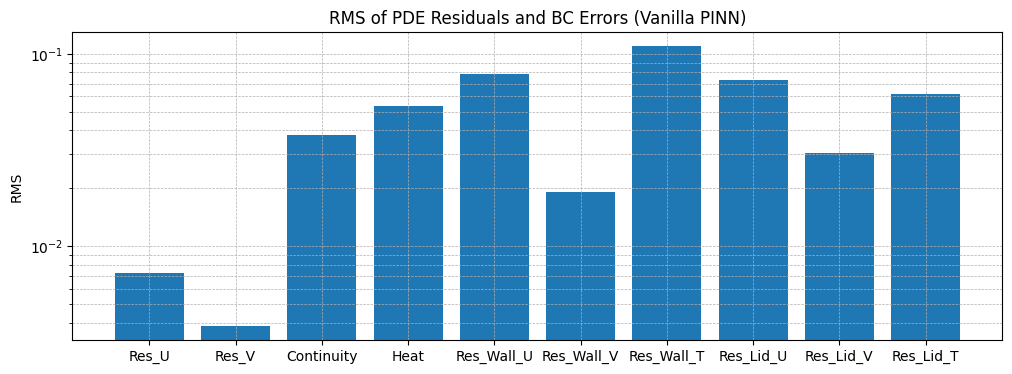

In [60]:
# Plotting Residuals RMS Values

res_u_rms,res_v_rms,res_c_rms,res_T_rms,res_wall_u_rms,res_wall_v_rms,res_wall_T_rms,res_lid_u_rms,res_lid_v_rms,res_lid_T_rms = compute_res_rms()

labels = ['Res_U','Res_V','Continuity','Heat','Res_Wall_U','Res_Wall_V','Res_Wall_T','Res_Lid_U','Res_Lid_V','Res_Lid_T']
values = [res_u_rms,res_v_rms,res_c_rms,res_T_rms,res_wall_u_rms,res_wall_v_rms,res_wall_T_rms,res_lid_u_rms,res_lid_v_rms,res_lid_T_rms]

plt.figure(figsize = (12,4))
plt.bar(labels,values)
plt.yscale('log')
plt.ylabel("RMS")
plt.title('RMS of PDE Residuals and BC Errors (Vanilla PINN)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [41]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  3045.49 MB


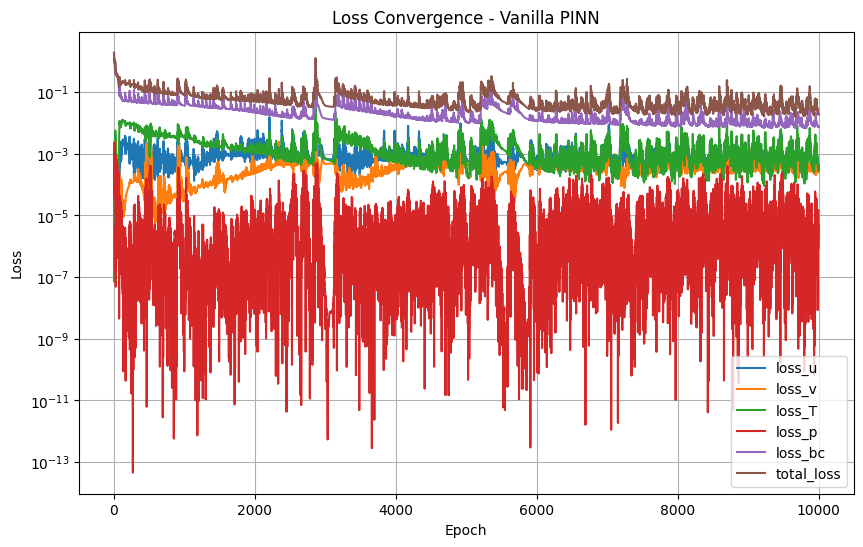

In [21]:
plt.figure(figsize=(10,6))
plt.plot(loss_u_list, label='loss_u')
plt.plot(loss_v_list, label='loss_v')
plt.plot(loss_T_list, label='loss_T')
plt.plot(loss_p_list, label='loss_p')
plt.plot(loss_bc_list, label='loss_bc')
plt.plot(total_loss_list, label='total_loss')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Convergence - Vanilla PINN'); plt.legend(); plt.grid(True)
plt.show()

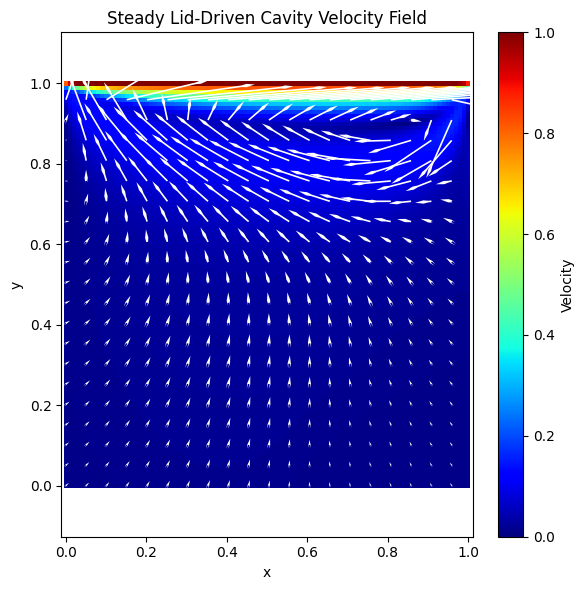

In [22]:
# Visualization

x = np.linspace(0,1,100)     # 100 X 1
y = np.linspace(0,1,100)     # 100 X 1

X,Y = np.meshgrid(x,y)       # Both 100 X 100

XY = np.stack([X.ravel(), Y.ravel()], axis = 1)    # 10000 X 2

net.eval()

with torch.no_grad():
    inp = torch.tensor(XY, dtype = torch.float32, device = device)
    output = net(inp).cpu().numpy()       # 10000 X 4 (u,v,p,t)

U = output[:, 0:1].reshape(100,100)   # 100 X 100
V = output[:,1:2].reshape(100,100)


speed = np.sqrt(U**2 + V**2)



plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,speed, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Velocity')

dx = slice(None, None, 5)
dy = slice(None, None, 5)

plt.quiver(X[dx,dy], Y[dx,dy], U[dx,dy], V[dx,dy], color='white', scale_units='xy', scale=1,
    width=0.004, headwidth=2, headlength=5, headaxislength=8, minlength=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Steady Lid-Driven Cavity Velocity Field')
plt.axis('equal')
plt.tight_layout()
plt.show()

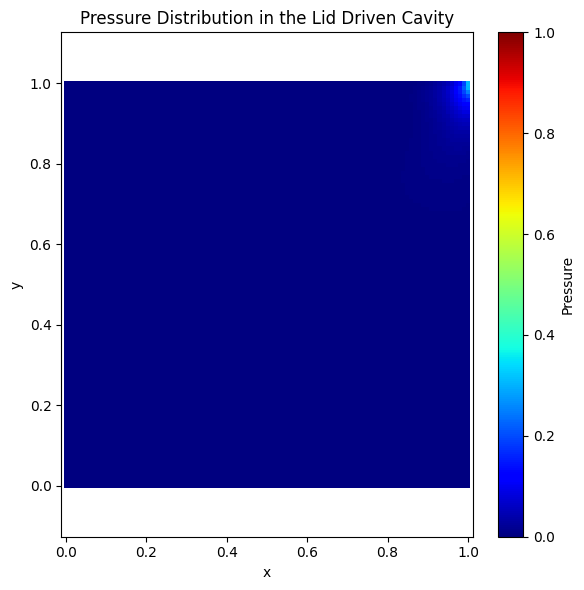

In [24]:
P = output[:,2:3].reshape(100,100)       # 100 X 100


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,P, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Pressure')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Pressure Distribution in the Lid Driven Cavity')
plt.axis('equal')
plt.tight_layout()
plt.show()



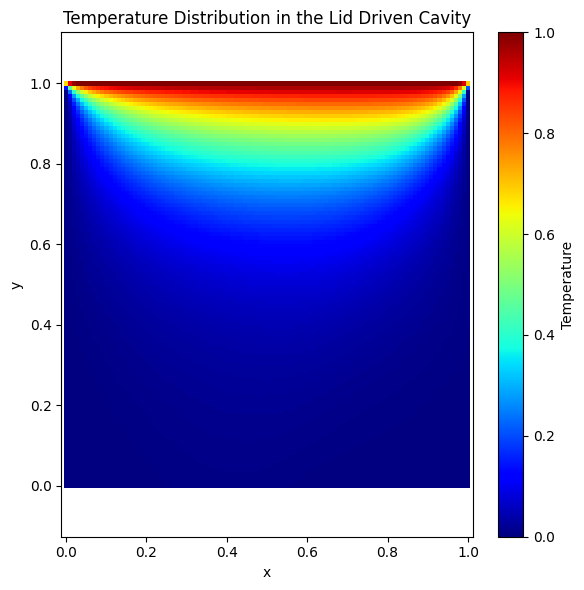

In [25]:
T = output[:,3:4].reshape(100,100)       # 100 X 100


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,T, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Temperature')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution in the Lid Driven Cavity')
plt.axis('equal')
plt.tight_layout()
plt.show()
